# Proyecto 5: Análisis de Grafos con Agrupamiento Espectral

- Martínez Ostoa Néstor Iván
- Datos Masivos II
- Lic. en Ciencia de Datos
- IIMAS, UNAM

---

**Objetivo**: identificar comunidades usando agrupamiento espectral

## Datos

- Nombre: 
    - *General Relativity and Quantum Cosmology collaboration network*
- Descripción: 
    - Gráfica de colaboradores en artículos de investigación sobre relatividad general y cosmología cuántica. 
    - Las aristas del dataset se construyeron si un autor $i$ fue co-autor de un artículo de investigación con un autor $j$
- Link al dataset: [aquí](https://snap.stanford.edu/data/ca-GrQc.html)

---

## Agrupamiento espectral

- Es un tipo de agrupamiento por conectividad en donde los puntos que están conectados o inmediatamente cercados se agrupan en el mismo grupo sin importar si la distancia entre dos puntos es menor, no se agruparán si no están conectados entre sí

<img src="https://drive.google.com/uc?export=view&id=1CKbIv3GCCtnsQ5anSSNj_yFS3ZdDAoYb"  width="700">

- En el agrupamiento espectral, los datos soon tratados como nodoos en un grafo por lo que este tipo de agrupamiento se enfoca como un problema de partición de grafos

- Concretamente, los nodos se transforman a un espacio de menor dimensión para que se puedan, después, agrupar en grupos

### Pasos

1. **Calcular la matriz de similiridad**
    
    - Podemos construirla a través de tres opciones:
        - **Gráfica en el vecindario $\epsilon$:** se conectan todos los puntos cuya distancia sea menor que $\epsilon$
        - **Gráfica KNN:** utilizamos el algorimo de los $K$ vecinos más cercanos para conectar vertices
        - **Gráfica fuertemente conexa:** conectamos todos los puntos entre sí y pesamos las aristas con una similaridad $s_{jj}$. Dicha similaridad se calcula a través de la función Gaussiana $$s(x_i, x_j) = \exp \left (-\frac{||x_i-x_j||^2}{2\sigma ^2} \right )$$
    
2. **Proyectar los datos a un espacio de menor dimensión**

    - Utilizamos la matriz Laplaciana la cual se calcula de la siguiente forma $$L=D-A$$
    - Donde $A$ es la matriz de adyacencia y $D$ es la matriz de grados de tal forma que $$d_i = \sum_{\{j|(i,j)\in E\}}w_{ij}$$
    - De tal forma que $$L_{ij} = \begin{cases}d_i & \text{si}\; i=j\\ -w_{ij} & \text{si}\; (i,j)\in E \\ 0 & \text{si}\; (i,j)\notin E\end{cases}$$
    - El objetivo de la matriz Laplaciana es encontrar los eigenvalores y eigenvectores para poder transformar los datos a una dimensión menor

3. **Creación de _clusters_**

    - Utilizamos el eigenvector correspondiente al segundo eigenvalor para asignar valores a cada nodo
    - El segundo eigenvalor indica el nivel de conexión entre los nodos


- [Referencia](https://towardsdatascience.com/spectral-clustering-82d3cff3d3b7)

## Librerías requeridas

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans, SpectralClustering
import scipy as sp

np.random.seed(23)

In [2]:
DATA_PATH = 'data/ca-GrQc.txt'
df = pd.read_csv(DATA_PATH, sep='\s+', skiprows=3)
df = df.sample(n=50, random_state=23)
print(df.shape)
df.head()

(50, 2)


,FromNodeId,ToNodeId
7061,3630,23939
277,4846,2133
16665,4513,2741
19301,12885,15999
3746,16091,11052


In [3]:
num_nodes = set()
for n in df["FromNodeId"].unique(): num_nodes.add(n)
for n in df["ToNodeId"].unique(): num_nodes.add(n)
print(f"Number of nodes: {len(num_nodes)}")
print(f"Number of edges: {df.shape[0] / 2}")

Number of nodes: 96
Number of edges: 25.0


In [4]:
df.to_csv('data/sampled_data.txt', index=False, sep=' ')

## Agrupamiento espectral - paso a paso

1. Construcción del grafo
2. Obtenemos la matriz de adyacencia
3. Obtenemos la matriz Laplaciana
4. Calculamos los primeros $k$ eigenvalores y eigenvectores de la matriz laplaciana
5. Visualización de los eigenvectores
6. Aplicamos el algoritmo $k$-medias para el agrupamiento de nodos
7. Visualizamos los clusters

### Construcción del grafo

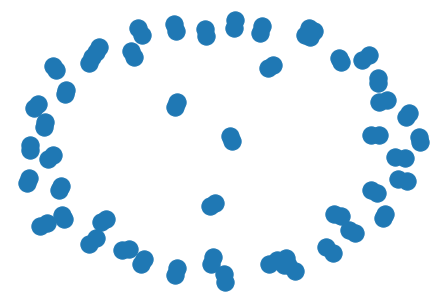

In [5]:
G = nx.Graph()

curr_node = 0
graph_dict = dict()

for idx, row in df.iterrows():
    u = row["FromNodeId"]
    v = row["ToNodeId"]
    if u not in graph_dict:
        graph_dict[u] = curr_node
        curr_node += 1
        
    if v not in graph_dict:
        graph_dict[v] = curr_node
        curr_node += 1
    
    G.add_edge(graph_dict[u], graph_dict[v])

nx.draw(G, pos=nx.spring_layout(G))

### Matriz de adyacencia $A$

In [6]:
A = nx.linalg.adjacency_matrix(G)
print(f"Dimensiones de A: {A.toarray().shape}\n")
print(A.toarray())

Dimensiones de A: (96, 96)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


### Matriz Laplaciana $L$

In [7]:
L = nx.linalg.laplacian_matrix(G)
L = L.toarray()
print(f"Dimeniones de L: {L.shape}\n")
print(f"Valores de la diagonal de L ({L.diagonal().shape[0]}): \n", L.diagonal())

Dimeniones de L: (96, 96)

Valores de la diagonal de L (96): 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### $k$-eigenvectores

In [8]:
eigen_values, eigen_vectors = np.linalg.eigh(L.astype(np.float64))

sorted_eigen_idxs = np.argsort(eigen_values)
eigen_values = eigen_values[sorted_eigen_idxs]
eigen_vectors = eigen_vectors[sorted_eigen_idxs]

In [9]:
eigen_values

array([-6.82190543e-16, -6.67104359e-16, -5.12086761e-16, -4.07647856e-16,
       -2.19781147e-16, -2.17201517e-16, -2.10603766e-16,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.95426554e-16,  8.33410614e-16,  5.85786438e-01,  5.85786438e-01,
        2.00000000e+00,  2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        2.00000000e+00,  

In [10]:
eigen_vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Visualización de los eigenvectores

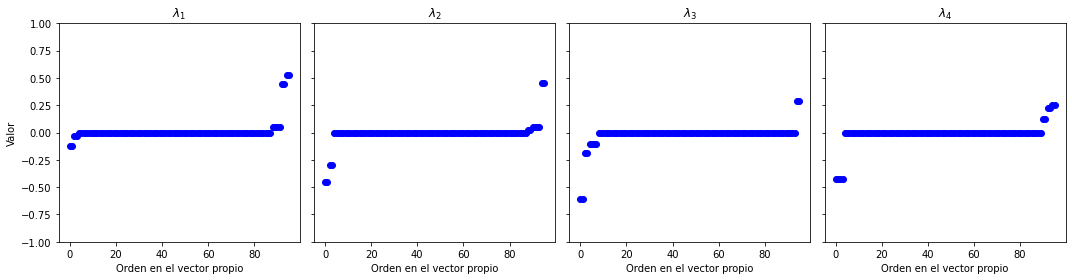

In [11]:
fig, axs = plt.subplots(1,4, figsize=(15, 4), sharey=True)

for i in range(4):
  axs[i].plot(np.sort(eigen_vectors[:, i]), 'bo')
  axs[i].set_ylim([-1,1])
  axs[i].set_xlabel('Orden en el vector propio')
  axs[i].set_title('$\\lambda_' + str(i + 1) + '$')

axs[0].set_ylabel('Valor')
fig.tight_layout()
plt.show()

### Aplicación de $k$-means

In [12]:
km = KMeans(n_clusters=3, n_init=100)
km = km.fit(eigen_vectors[:, [1]])
print(km.labels_.shape)
km.labels_

(96,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

### Visualización de los clusters

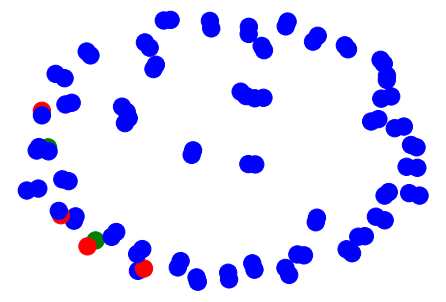

In [13]:
mapa_color = {0:'blue', 1:'red', 2:'green'}
color_vertices = [mapa_color[km.labels_[n]] for n in G]
nx.draw(G, pos=nx.spring_layout(G), node_color=color_vertices)

## Agrupamiento espectral - scikit learn

In [20]:
X = []
for edge in G.nodes():
    X.append([edge])
X = np.array(X)

In [21]:
clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=23).fit(X)
print(clustering.labels_.shape)
clustering.labels_

(96,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

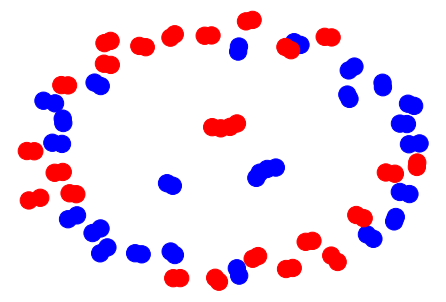

In [22]:
mapa_color = {0:'blue', 1:'red', 2:'green'}
color_vertices = [mapa_color[clustering.labels_[n]] for n in G]

nx.draw(G, pos=nx.spring_layout(G), node_color=color_vertices)

## Agrupamiento espectral - NetworkX

In [17]:
DATA_PATH = 'data/sampled_data.txt'
G_large = nx.read_edgelist(DATA_PATH)
large_pos = nx.spring_layout(G_large)

In [18]:
amat_large = nx.linalg.adjacency_matrix(G_large)
sc_large = SpectralClustering(n_clusters=3, 
                              affinity='precomputed', 
                              n_init=100)
sc_large = sc_large.fit(amat_large)

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


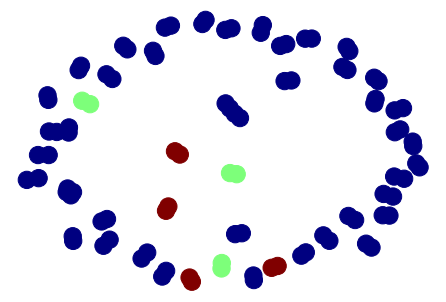

In [19]:
nx.draw(G_large, pos=large_pos, node_color=sc_large.labels_, cmap=plt.cm.jet)

## Conclusiones

- De los tres agrupamientos realizados (manual, scikit learn, networkx), podemos observar que con base en la forma de los datos, el mejor agrupamiento es el realizado por networkx puesto que el circulo exterior lo muestra de color azul oscuro, y los puntos dentro del círculo de los otros dos colores
- El agrupamiento espectral realizado de manera manual parece que no logra agrupar de la mejor manera pues agrupa a la mayoría de los puntos en un mismo cluster (azul)
- Finalmente, el agrupamiento por scikit learn, podría considerarse como el peor de los tres puesto que el agrupamiento que realiza no corresponde nada con la forma de los datos aún cuando el número de clusters propuesto es de 2